In [1]:
import sys
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
import time # For timing

from qcml.manifolds import CircleManifold
from qcml.manifolds import SphereManifold
from qcml.matrix_trainer import MatrixConfigurationTrainer
from qcml.dimension_estimator import DimensionEstimator
from qcml.visualization.manifold_plots import (
    plot_3d_points,
    plot_pointwise_eigenvalues, # Function to plot eigenvalues vs point index
    plot_2d_reconstruction, # Added for Supplementary Figure 1
    compare_original_vs_reconstructed,
)

from qcml.visualization.training_plots import plot_training_curves

In [2]:
# Common parameters
N = 4
D = 3 # Embedding dimension for sphere
true_dim = 2
n_points_train = 2500
manifold_noise_std = 0.1 # Specific to this test (noiseless)

# Parameters for noise=0 case
n_epochs = 100
learning_rate = 0.01
w_qf = 0.2 # Set w_qf to 0.0 for the noiseless case (based on Figure 2 in paper)
batch_size = 500

output_dir = Path("./test_outputs/figure1")
output_dir.mkdir(parents=True, exist_ok=True)

# Set random seeds for reproducibility
seed = 42

In [3]:
# --- Data Generation ---
print(f"Generating {n_points_train} training points with noise std = {manifold_noise_std}...")
manifold = SphereManifold(dimension=D, noise=manifold_noise_std)
train_points = manifold.generate_points(n_points_train,np_seed=seed)

Generating 2500 training points with noise std = 0.1...


(<Figure size 800x800 with 1 Axes>,
 <Axes3D: title={'center': 'Input Training Data X (noise = 0.1)'}, xlabel='X axis', ylabel='Y axis', zlabel='Z axis'>)

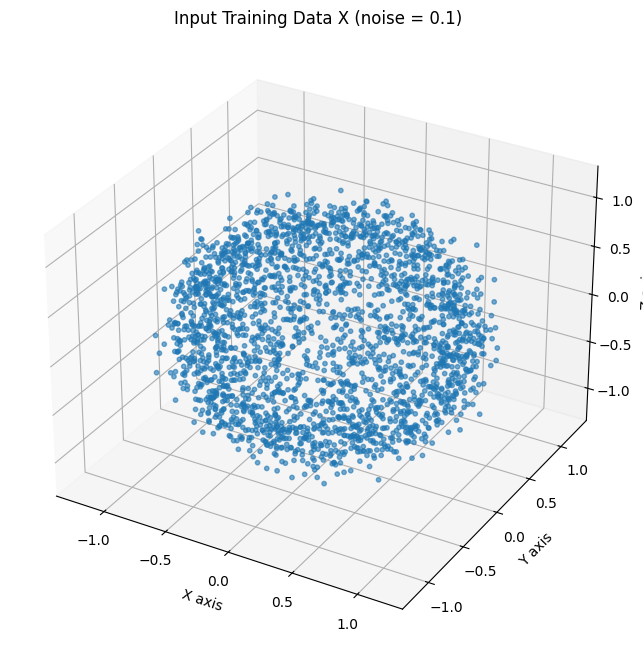

In [4]:
#input_plot_filename = f"fig1_a_input_points.png"
#save_path=output_dir / input_plot_filename
plot_3d_points(
    train_points, # Convert for plotting
    title=f"Input Training Data X (noise = {manifold_noise_std})"
)

In [5]:
trainer = MatrixConfigurationTrainer(
    N=N,
    D=D,
    points_np=train_points,
    learning_rate=learning_rate,
    quantum_fluctuation_weight=w_qf
)

--- Device Setup ---
CUDA Available: False
Using device: cpu
--------------------
[TIME] Device setup took: 0.0020s
[TIME] TOTAL __init__ setup before matrix init: 0.0020s
[TIME] Matrix initialization took: 0.0728s
[TIME] Moving model to device took: 0.0025s
[MatrixTrainer Init] Trainer using device: cpu
[MatrixTrainer Init] Parameter matrix device: cpu
[TIME] Optimizer init took: 2.0161s
[TIME] TOTAL __init__ took: 2.0935s
--- Stored 2500 points on device: cpu ---


In [6]:
history = trainer.train_matrix_configuration(
    n_epochs=n_epochs,
    batch_size=batch_size,
    verbose=True
)

[Train] Using stored tensor with 2500 points on device: cpu
--- Using mini-batch training (batch size = 500) ---
Epoch 1/100, Loss: 0.311707, Recon: 0.222475, QF: 0.446162, LR: 0.010000
Epoch 11/100, Loss: 0.166962, Recon: 0.052358, QF: 0.573018, LR: 0.010000
Epoch 21/100, Loss: 0.164812, Recon: 0.053509, QF: 0.556515, LR: 0.010000
Epoch 31/100, Loss: 0.164536, Recon: 0.054215, QF: 0.551607, LR: 0.010000
Epoch 41/100, Loss: 0.164420, Recon: 0.053719, QF: 0.553506, LR: 0.010000
Epoch 51/100, Loss: 0.164319, Recon: 0.053450, QF: 0.554342, LR: 0.010000
Epoch 61/100, Loss: 0.164284, Recon: 0.053402, QF: 0.554411, LR: 0.010000
Epoch 71/100, Loss: 0.164272, Recon: 0.053295, QF: 0.554886, LR: 0.010000
Epoch 81/100, Loss: 0.164307, Recon: 0.053438, QF: 0.554348, LR: 0.010000
Epoch 91/100, Loss: 0.164305, Recon: 0.053566, QF: 0.553695, LR: 0.010000
Epoch 100/100, Loss: 0.164306, Recon: 0.053247, QF: 0.555296, LR: 0.010000


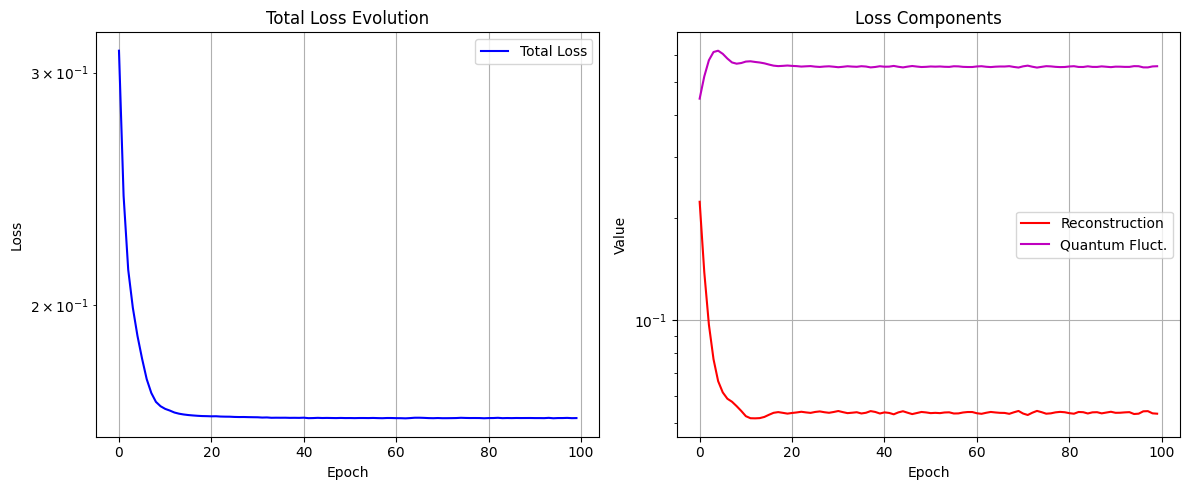

(<Figure size 1200x500 with 2 Axes>,
 [<Axes: title={'center': 'Total Loss Evolution'}, xlabel='Epoch', ylabel='Loss'>,
  <Axes: title={'center': 'Loss Components'}, xlabel='Epoch', ylabel='Value'>])

In [7]:
# plot training curves
plot_training_curves(history)

--- Reconstructing points provided during initialization. ---


(<Figure size 800x800 with 1 Axes>,
 <Axes3D: title={'center': 'Reconstructed Points'}, xlabel='X axis', ylabel='Y axis', zlabel='Z axis'>)

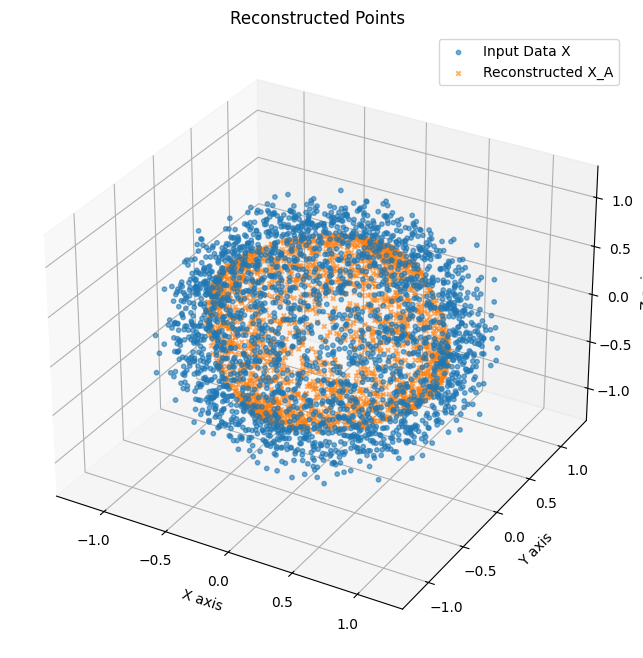

In [8]:
reconstructed_points = trainer.reconstruct_points() 

plot_3d_points(
    train_points,
    reconstructed_points,
    title=f"Reconstructed Points"
)

In [9]:
estimator = DimensionEstimator(trainer)
eigenvalues = estimator.compute_eigenspectrum(train_points)
if eigenvalues is not None and eigenvalues.shape[1] > 2:
    print(f"Noise={manifold_noise_std}, Eigenvalues shape: {eigenvalues.shape}, e2 min/max/mean: {eigenvalues[:, 2].min():.4f}/{eigenvalues[:, 2].max():.4f}/{eigenvalues[:, 2].mean():.4f}")

Computing quantum metrics first...

Computing quantum metrics (Vectorized Sum-over-States Eq. 7) for 2500 points (N=4, D=3)...
--- Computing eigensystem for provided 2500 points. ---
Quantum metrics (Internal Tensor Sum-over-States Eq. 7) computation completed.
Computing eigenvalues for metrics tensor shape: torch.Size([2500, 3, 3])
Computed eigenvalues shape: torch.Size([2500, 3])
Noise=0.1, Eigenvalues shape: torch.Size([2500, 3]), e2 min/max/mean: 0.2752/2.8937/1.0916
